# Sktime ARIMA tutorial (firts draft)
### Authors: Andreev Mikhail, Markin Nikita, Lobachev Nikita



## In this notebook one can find the pipline for working with sktime library on the topic of ARIMA model.
### Content of the motebook:


1.   Preparing the environment
2.   Dataset preprocessing
3.   Estimation of one particular ARIMA model with following equation
4.   Estimation of the best model on the basis of autoARIMA function
5.   Visualisation of the archieved results
5.   Evaluation of the models with sliding window
5.   --//--




## Installation of all required packages

In [ ]:
!pip install sktime
!pip install pmdarima

     |████████████████████████████████| 5.7MB 6.3MB/s 
     |████████████████████████████████| 22.2MB 1.4MB/s 
     |████████████████████████████████| 9.5MB 40.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 1.5MB 5.1MB/s 
     |████████████████████████████████| 2.1MB 17.0MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [ ]:
from sktime.datasets import load_airline # the academic dataset build in the library, (IS NOT USED IN THE TUTORIAL)
from sktime.utils.plotting import plot_series # Function for visualisation of data on the graph
from sktime.forecasting.model_selection import temporal_train_test_split # splitting function for dividing data into train and test 
from sktime.forecasting.model_selection import (  # Functions for implementing comparison of models using Sliding Window 
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

## Downloading the data in csv format

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/TSSP/dat.zip

In [ ]:
df = pd.read_csv("/content/GlobalTemperatures.csv", encoding='utf-8') # Tenperature data
#data is available at: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data


### Choose only the columns with date and target variable, the one that will be predicted

In [ ]:
df.drop(["LandMaxTemperature", "LandMaxTemperatureUncertainty",
         "LandMinTemperature", "LandMinTemperatureUncertainty",
         "LandAndOceanAverageTemperature", "LandAndOceanAverageTemperatureUncertainty"],
        axis=1, inplace=True)
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574
1,1750-02-01,3.083,3.702
2,1750-03-01,5.626,3.076
3,1750-04-01,8.490,2.451
4,1750-05-01,11.573,2.072


### Convert date column to the datetime type 

If it accidantely wasn't yet

In [ ]:
date_from_which = '1990-01' # specification of the year starting from which data will be included in the dataset
df["dt"] = pd.to_datetime(df["dt"], format='%Y-%m-%d', errors='coerce')
df = df.loc[df['dt']>=date_from_which]
df['dt'] = pd.date_range(start=date_from_which, end='2016-01-01', freq='M')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty
2880,1990-01-31,3.243,0.090
2881,1990-02-28,3.643,0.087
2882,1990-03-31,6.730,0.099
2883,1990-04-30,9.169,0.059
2884,1990-05-31,11.831,0.071


### Construct new data entity "y" of type Pandas.Series 

### It will have dates as indices and target variable as a column

#### **It is the crutual part, because sktime works only with such datatype.**

In [ ]:
df["dt"] = pd.to_datetime(df["dt"])
y = pd.Series(df['LandAverageTemperature'].values , index=df['dt'])
y = y.asfreq('M') # frequency is M since we iterate by months
y.head()


dt
1990-01-31     3.243
1990-02-28     3.643
1990-03-31     6.730
1990-04-30     9.169
1990-05-31    11.831
Freq: M, dtype: float64

## Visualisation of the data divided to test and train parts
#### In this example we know from other sources of information that avarage temperature increases faster in last years. 
#### This information will be helpful for constructing a model

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5e66d2ddd8>)

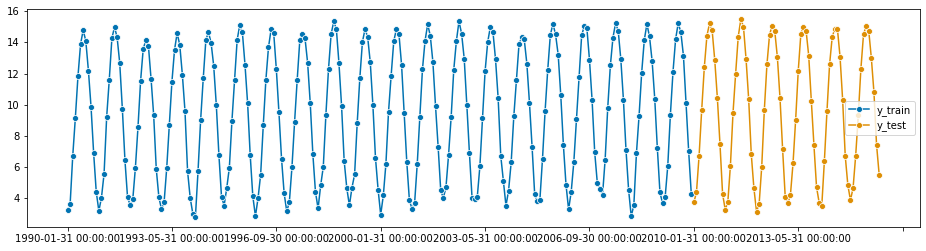

In [ ]:
y_train, y_test = temporal_train_test_split(y, test_size=72) # test size is chosen to be last 6 years
from sktime.utils.plotting import plot_series                # the function which visualize the series
plot_series(y_train, y_test, labels=["y_train", "y_test"])

##### From the picture we see that the process is stationary and therefore we guess for 0 in the middle of ARIMA parameters.

###Hand picked parameters for Arima model

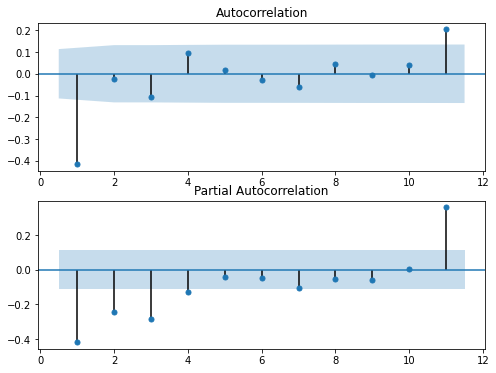

In [ ]:
import statsmodels.graphics.tsaplots as sg

temp_diff = y.diff().diff(12).dropna()
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
sg.plot_acf(temp_diff, lags=11, zero=False, ax=ax1)
sg.plot_pacf(temp_diff, lags=11, zero=False, ax=ax2)
plt.show()

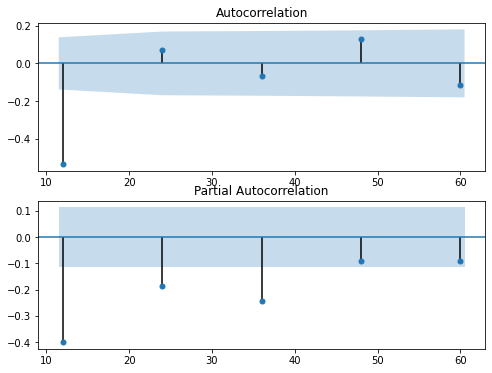

In [ ]:
# Seasonal part

# Make list of lags
lags = [12, 24, 36, 48, 60]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
sg.plot_acf(temp_diff, lags=lags, zero=False, ax=ax1)
sg.plot_pacf(temp_diff, lags=lags, zero=False, ax=ax2)
plt.show()

0.0371994317188781

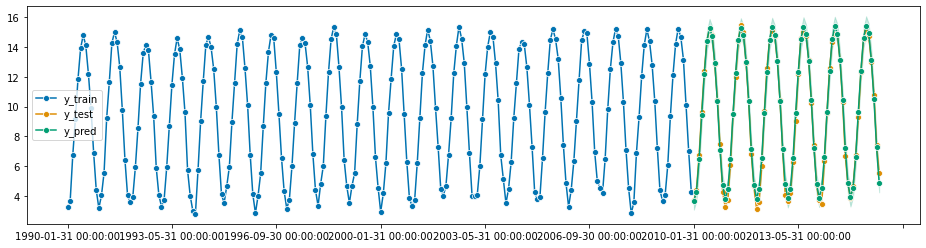

In [ ]:
forecaster = ARIMA(
    order=(3, 0, 0), seasonal_order=(0, 1, 3, 12), suppress_warnings=True
)
forecaster.fit(y_train)
horizon = ForecastingHorizon(y_test.index, is_relative=False)
y_pred, pred_ints = forecaster.predict(horizon, return_pred_int=True, alpha=0.05)
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
smape_loss(y_test, y_pred)

In [ ]:
print(forecaster.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  240
Model:             SARIMAX(3, 0, 0)x(0, 1, [1, 2, 3], 12)   Log Likelihood                 -58.503
Date:                                    Wed, 03 Feb 2021   AIC                            133.005
Time:                                            17:18:31   BIC                            160.440
Sample:                                                 0   HQIC                           144.074
                                                    - 240                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0160      0.004      4.061      0

After series analysis the model we used here was Seasonal Arima with parameters (3,0,0), (0, 1, 3). Or we can write it as: $y_t = a1 * y_{t-12} + a2 * y_{t-24} + a3 * y_{t-36} + m1 * \epsilon_{t-12} + m2 * \epsilon_{t-24} + m3 * \epsilon_{t-36} + \epsilon_t$

## Implementing of autoARIMA function
 

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: 

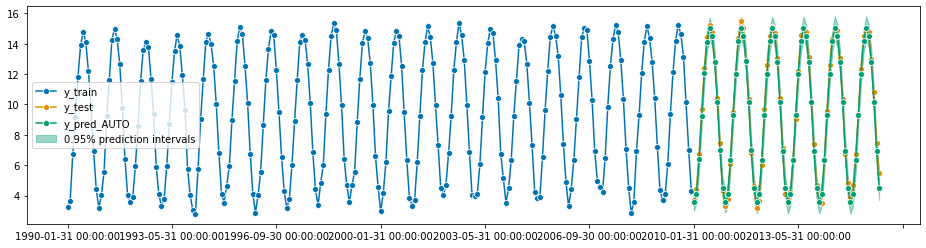

In [ ]:
## FORECASTING ##

Auto_arima_model = AutoARIMA(auto=True, sp = 12)                  # 12 since there are 12 months in a year 
Auto_arima_model.fit(y_train)                                     # We fit the model on our data
horizon = ForecastingHorizon(y_test.index, is_relative=False)     # Forecasting Horizon is the time segment which is under the scope of prediction

alpha = 0.05                                                      # 95% predictive interval
y_pred_AUTO, pred_ints = Auto_arima_model.predict(horizon,
               return_pred_int=True, alpha=alpha)                 # Predict the value of target variable for dates in the horizon

## VISUALIZATION ##

fig, ax = plot_series(y_train, y_test, y_pred_AUTO,
    labels=["y_train", "y_test", "y_pred_AUTO"])                  # plot the results with labels=[] 
ax.fill_between(                                                  # function for depicting the predictive intervals
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.4,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();


###Now lets visualize only the test part
#### We just delete the y _train from the function plot_series()

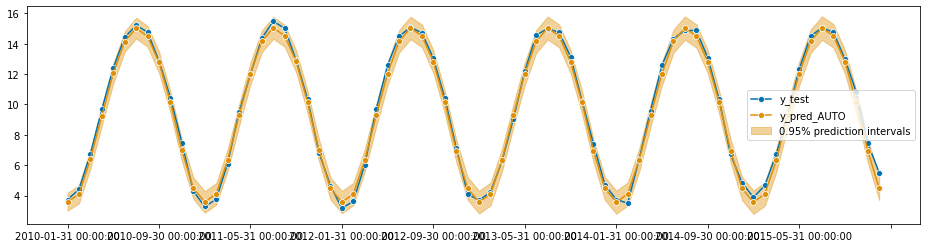

In [ ]:
fig, ax = plot_series(y_test, y_pred_AUTO,
    labels=["y_test", "y_pred_AUTO"])             
ax.fill_between(                                               
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.4,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

## In order to compare the results with the test data we use smape_loss

In [ ]:
from sktime.performance_metrics.forecasting import smape_loss

$$smape(y, \hat y) = \frac{1}{H} \sum_{i=T+1}^{T+H} \frac{|y_i - \hat y_i|}{|y_i| + |\hat y_i|}$$


In [ ]:
print(smape_loss(y_test, y_pred_AUTO))

0.040655252911252465


## All the informatin about the chosen model is accessable in **model.summary()**

In [ ]:
Auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  240
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 12)   Log Likelihood                 -59.371
Date:                              Wed, 03 Feb 2021   AIC                            132.741
Time:                                      17:16:01   BIC                            156.747
Sample:                                           0   HQIC                           142.427
                                              - 240                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0091      0.094     -0.097      0.923      -0.193       0.175
ar.L2          0.8671      0.095      9.139      0.000       0.681       1.053
ma.L1          0.2396      0.119      2.005      0.045       0.005       0.474
ma.L2         -0.5572      0.105     -5.314      0.000      -0.763      -0.352
ar.S.L12      -0.1916      0.075     -2.554      0.011      -0.339      -0.045
ma.S.L12      -0.8585      0.087     -9.874      0.000      -1.029      -0.688
sigma2         0.0906      0.008     10.722      0.000       0.074       0.107
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 2.00
Prob(Q):                              0.70   Prob(JB):                         0.37
Heteroskedasticity (H):               1.05   Skew:                            -0.12
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Finally, lets compare some models using Sliding Window

In [ ]:
cv = SlidingWindowSplitter(
    initial_window=int(len(y_train) * 0.5),
)

orders = [(3, 0, 0),
          (1, 1, 1),
          (2, 0, 2)]

seasonal_orders = [(0, 1, 3, 12),
                   (1, 1, 1, 12),]

forecaster_param_grid = {"order": orders, "seasonal_order": seasonal_orders}
forecaster = ARIMA(suppress_warnings=True)

gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, verbose=True
)
gscv.fit(y_train)

Fitting 240 folds for each of 6 candidates, totalling 1440 fits


In [ ]:
gscv.best_forecaster_

ARIMA(order=(1, 2, 1), seasonal_order=(1, 1, 1, 12), suppress_warnings=True)

Что ждем от туториала?

1. Оценить конкретную модель заданного класса.
Не только сделать .fit, но и выписать полученное уравнение!
2. Автоматически подобрать модель (встроенный подбор)
3. Построить графики прогнозов, интервальные прогнозы где есть.
4. Сравнить несколько (две-три) модели данного класса с помощью скользящего окна.
5. Творчество, любые дополнения, мемасики :)

Класс выбираем: ETS, ARIMA, BATS + TBATS, PROPHET, случайный лес + создание признаков, GARCH, своё предложить

Цель: когда через год будут люди спрашивать "как в питоне оценить ets/arima?" ответ должен быть "читайте туториалы от нашего курса!"